In [1]:
import pandas as pd 
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m

warnings.filterwarnings('ignore')
randomseed=7

In [4]:
data1=pd.read_csv('NextYearData_actualData_train.txt')
data2=pd.read_csv('ThisYearData_actualData_train.txt')
data3=pd.read_csv('ThisYearData_actualData.txt')

data4=pd.read_csv('NextYearData_actualData.txt')

data5=pd.read_csv('Predicted_NextYearData.txt')
data5.columns=data4.columns

data=pd.concat([data1,data2,data3])

print(data.shape)
data.head()

(70592, 16)


,Unnamed: 0,FIELD_1,FIELD_2,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,L100800,CLASS
0,0,696760,20150404,5.67,89.0,24.3,13.0,3.8,1.0,0.0,0.0,1.0,1.0,39.0,96.0,0
1,1,819364,20150923,5.80,173.0,26.2,13.0,4.8,1.0,0.0,0.0,0.0,1.0,43.0,92.0,0
2,2,816630,20170928,5.51,74.0,21.8,21.0,7.4,2.0,3.0,0.0,0.0,0.0,45.0,108.0,1
3,3,3869001,20161109,5.14,224.0,25.1,32.0,4.1,3.0,3.0,0.0,0.0,0.0,47.0,90.0,0
4,4,2853000,20161121,5.75,189.0,19.5,12.0,2.6,1.0,0.0,0.0,0.0,1.0,38.0,89.0,0


In [5]:
diabetic = data[data.CLASS==2]
prediabetic = data[data.CLASS==1]
normal = data[data.CLASS==0]

print(diabetic.shape[0],prediabetic.shape[0],normal.shape[0])

1043 19307 50242


In [67]:
diabetic_test = diabetic.sample(200,random_state=randomseed)
prediabetic_test = prediabetic.sample(200,random_state=randomseed)
normal_test = normal.sample(200,random_state=randomseed)
test=pd.concat([diabetic_test,prediabetic_test,normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(2*diabetic_train.shape[0],random_state=randomseed)
normal_train = normal.drop(normal_test.index).sample(2*diabetic_train.shape[0],random_state=randomseed)
train=pd.concat([diabetic_train,diabetic_train,prediabetic_train,normal_train])

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=randomseed,n_estimators=1000,max_depth=12,
                          min_samples_split=2, min_samples_leaf = 10, max_features =  'auto'   )
rf.fit(train.iloc[:,3:-2],train.iloc[:,-1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.6983333333333334


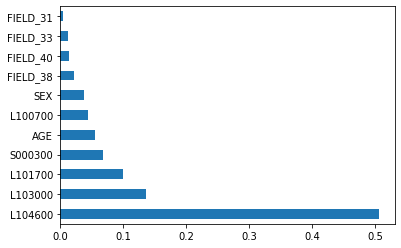

Index(['L104600', 'L103000', 'L101700', 'S000300', 'AGE', 'L100700', 'SEX',
       'FIELD_38', 'FIELD_40', 'FIELD_33', 'FIELD_31'],
      dtype='object')


In [69]:
ypred= rf.predict(test.iloc[:,3:-2])

score=rf.score(test.iloc[:,3:-2],test.iloc[:,-1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:,3:-2].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(16).index)

In [70]:
print("Accuracy on training set: {:.3f}".format(rf.score(train.iloc[:,3:-2],train.iloc[:,-1])))
print("Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:,3:-2],test.iloc[:,-1] )))  

confmatrx=pd.DataFrame(m.confusion_matrix(test.iloc[:,-1],ypred))
confmatrx.head()

Accuracy on training set: 0.810
Accuracy on test set: 0.698


,0,1,2
0,128,72,0
1,57,125,18
2,0,34,166


In [71]:

from sklearn.metrics import classification_report 
print(classification_report(test.iloc[:,-1], ypred))


              precision    recall  f1-score   support

           0       0.69      0.64      0.66       200
           1       0.54      0.62      0.58       200
           2       0.90      0.83      0.86       200

    accuracy                           0.70       600
   macro avg       0.71      0.70      0.70       600
weighted avg       0.71      0.70      0.70       600



In [72]:
import xgboost as xgb
from sklearn import metrics as m
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(train.iloc[:,3:-2],train.iloc[:,-1])

y_pred = xgb_model.predict((test.iloc[:,3:-2]))

print('accuracy \t',m.accuracy_score(test.iloc[:,-1],y_pred))
confmatrx=pd.DataFrame(m.confusion_matrix(test.iloc[:,-1],y_pred))
confmatrx.head()

accuracy 	 0.715


,0,1,2
0,130,67,3
1,51,134,15
2,2,33,165


In [73]:
print(classification_report(test.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       200
           1       0.57      0.67      0.62       200
           2       0.90      0.82      0.86       200

    accuracy                           0.71       600
   macro avg       0.73      0.71      0.72       600
weighted avg       0.73      0.71      0.72       600



In [74]:
# =====================================
pred5= rf.predict((data5.iloc[:,3:-2]))

print(m.accuracy_score(data5.iloc[:,-1],pred5))

confmatrx=pd.DataFrame(m.confusion_matrix(data5.iloc[:,-1],pred5))
confmatrx

0.6617434580189436


,0,1,2
0,5596,2950,34
1,950,2473,219
2,4,57,175


In [75]:
print(classification_report(data5.iloc[:,-1], pred5))

              precision    recall  f1-score   support

           0       0.85      0.65      0.74      8580
           1       0.45      0.68      0.54      3642
           2       0.41      0.74      0.53       236

    accuracy                           0.66     12458
   macro avg       0.57      0.69      0.60     12458
weighted avg       0.73      0.66      0.68     12458

